# D3 Plugins: Truly Interactive Matplotlib In Your Browser

*This notebook originally appeared as a*
[*blog post*](http://jakevdp.github.io/blog/2014/01/10/d3-plugins-truly-interactive/)
*by Jake Vanderplas on*
[*Pythonic Perambulations*](http://jakevdp.github.io/).
*Content is BSD licensed*

**Update, March 2014: there are some major changes and refactorings in mpld3 version 0.1.
Because of this, some of the code below will not work with the current release: please
see the [mpld3 documentation](http://mpld3.github.io) for more information.**

<!-- PELICAN_BEGIN_SUMMARY -->

It's been a few weeks since I introduced [mpld3](http://github.com/jakevdp/mpld3), a
toolkit for visualizing matplotlib graphics in-browser via d3, and a lot of progress
has been made.  I've added a lot of features, and there have also been dozens of pull
requests from other users which have made the package much more complete.

One thing I recognized early was the potential to use mpld3 to add interactive bells
and whistles to matplotlib plots.  Yesterday, at the [#HackAAS](http://twitter.com/search?q=%23HackAAS) event at the
American Astronomical Society meeting, I had a solid chunk of time to
work this out.  The result is what I'll describe and demonstrate below: a general
plugin framework for matplotlib plots, which, given some d3 skills, can be utilized
to modify your matplotlib plots in almost any imaginable way.

<!-- PELICAN_END_SUMMARY -->

As a side note, #HackAAS was really, really awesome.  There were about 40-60 astronomers
there during the day, working on everything from visualization tools to data analysis
methods to visualization of gender-related data to natural language processing.
I've been told that a full report will be compiled at the [AstroBetter](http://www.astrobetter.com/) website,
and it will definitely be worth checking out.

## New Features of mpld3

Since my [last post](http://jakevdp.github.io/blog/2013/12/19/a-d3-viewer-for-matplotlib/),
there have been many new features implemented in mpld3.  Most
notably, fine-tuned axis and style control, histograms, scatter plots, images, color bars,
and tied zooming & panning are now in the package.  We'll see some of these below.

Another nice piece is that IPython notebook integration is now much more convenient.
Brian Granger of the IPython team submitted a nice patch which allows IPython to
automatically use mpld3 as a backend.  It can
be accomplished using the ``enable_notebook`` function:

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mpld3

# mpld3.enable_notebook()
mpld3.enable_notebook(d3_url='//mpld3.github.io/js/d3.v3.min.js',
                      mpld3_url='//mpld3.github.io/js/mpld3.v0.1.js')

As a quick demonstration, let's take a look at a simple scatter plot:

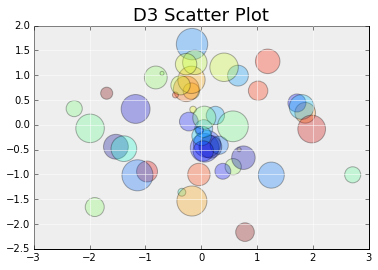

In [11]:
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
ax.grid(color='white', linestyle='solid')

N = 50
scatter = ax.scatter(np.random.normal(size=N),
                     np.random.normal(size=N),
                     c=np.random.random(size=N),
                     s = 1000 * np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)

ax.set_title("D3 Scatter Plot", size=18);

You can use your mouse or trackpad to pan and zoom around the figure, exploring the data.
Nearly all of the basic features of matplotlib are supported now, with a few exceptions that
I plan to work on as I find the time.  I'd encourage you to update the package, try out some
of your favorite plots, and see how they turn out!

## The Brand New Feature: Plugins

But all of that is now weeks old.  The real reason for this post is to
introduce the new interactive features I added during HackAAS.

My goal for the hack day was to create a plugin framework which would allow different
interactive d3/javascript/html/css elements to be added to the plots.
I implemented a couple plugins, and included one in the current master branch
of ``mpld3``: adding more should be pretty straightforward, and would be a great
way to contribute!  Here I'll show how to use this plugin to annotate the previous
scatter plot with information that appears when the mouse hovers over the points.

Here we'll define a set of labels to associate with our points, and add
a list of desired plugins to the figure object.  The two extra lines of
code at the bottom of this cell are all that are needed to make this 
happen!

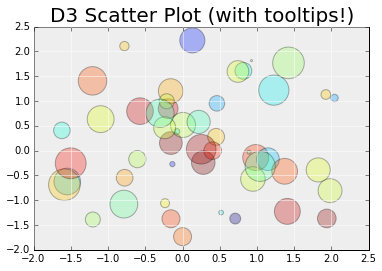

In [6]:
from mpld3 import plugins

fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
ax.grid(color='white', linestyle='solid')

N = 50
scatter = ax.scatter(np.random.normal(size=N),
                     np.random.normal(size=N),
                     c=np.random.random(size=N),
                     s = 1000 * np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)

ax.set_title("D3 Scatter Plot (with tooltips!)", size=20)

labels = ['point {0}'.format(i + 1) for i in range(N)]
fig.plugins = [plugins.PointLabelTooltip(scatter, labels)]

As you move your mouse around this plot, you should see the labels pop up
as you hover over the points.

## How this works

What's going on here is that the plugin object defines some HTML, CSS, and D3/Javascript snippets
which together implement the desired behavior.  Then when ``mpld3`` generates the html for a figure,
it identifies the list of plugins and injects the code at the appropriate place in the
HTML output.  You can take a look at the
[mpld3/plugins.py](https://github.com/jakevdp/mpld3/blob/master/mpld3/plugins.py)
source to get a feel for
how a plugin is implemented.  I tried to design the API to be flexible and extensible,
so that virtually any desired behavior can be added to a matplotlib plot.  The design still
has a few rough edges, but I think it's on its way to a really usable tool.

I should warn you that the details of this are likely to change in the near term: the internals
of the package are still evolving as we learn how to better represent the plots in D3.  But with
the current master branch, it is still quite easy to define a new plugin with some custom behavior:
as an example of this in action, let's build a basic plugin that will tie-together elements between
two different axes.

We'll start by creating a toy dataset: we'll randomly draw a number of periods and amplitudes,
and from these create a sinusoidal time-series.  In a typical static matplotlib plot, it might
look something like this:

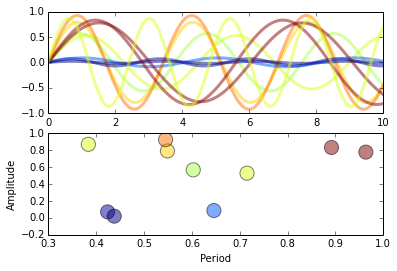

In [4]:
np.random.seed(0)

P = np.random.random(size=10)
A = np.random.random(size=10)

x = np.linspace(0, 10, 100)
data = np.array([[x, Ai * np.sin(x / Pi)]
                 for (Ai, Pi) in zip(A, P)])

fig, ax = plt.subplots(2)

points = ax[1].scatter(P, A, c=P + A,
                       s=200, alpha=0.5)
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Amplitude')

colors = plt.cm.ScalarMappable().to_rgba(P + A)

for (x, l), c in zip(data, colors):
    ax[0].plot(x, l, c=c, alpha=0.5, lw=3)

We've plotted all the curves, but it's a bit crowded.  It would be nice if
this were interactive in more than just zooming and panning: the relationships between
the data would be much more clear if by hovering over the points in the bottom plot,
we could more easily identify the corresponding line in the top plot.
There are many ways in which this might be accomplished, but we'll take the
approach of showing the desired line after hovering over the associated point.

To do this, all we need is to create a plugin class deriving from PluginBase,
which writes a few extra lines of javascript into the figure rendering:

In [5]:
from mpld3.plugins import PluginBase
import jinja2
import json


class LinkedView(PluginBase):
    """A simple plugin showing how multiple axes can be linked"""
    
    FIG_JS = jinja2.Template("""
    var linedata{{ id }} = {{ linedata }};

    ax{{ axid }}.axes.selectAll(".paths{{ collid }}")
	    .on("mouseover", function(d, i){
             line{{ elid }}.data = linedata{{ id }}[i];
             line{{ elid }}.lineobj.transition()
                .attr("d", line{{ elid }}.line(line{{ elid }}.data))
                .style("stroke", this.style.fill);})
    """)

    def __init__(self, points, line, linedata):
        self.points = points
        self.line = line
        self.linedata = linedata
        self.id = self.generate_unique_id()

    def _fig_js_args(self):
        points = self._get_d3obj(self.points)
        line = self._get_d3obj(self.line)
        return dict(id=self.id,
                    axid=points.axid,
                    collid=points.collid,
                    elid=line.elid,
                    lineaxid=line.axid,
                    lineid=line.lineid,
                    linedata=json.dumps(self.linedata))

Now we'll re-create the plot, adding our plugin to the figure.  Instead
of plotting all the lines here, we plot just a single line instance which
the plugin will modify.  The result is a much more compelling visualization
of the data.

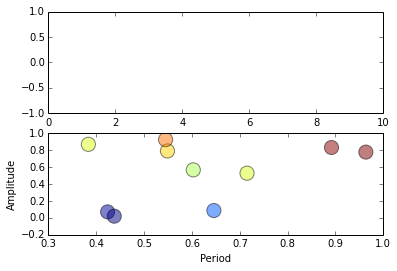

In [6]:
fig, ax = plt.subplots(2)

# scatter periods and amplitudes
np.random.seed(0)
P = np.random.random(size=10)
A = np.random.random(size=10)
x = np.linspace(0, 10, 100)
data = np.array([[x, Ai * np.sin(x / Pi)]
                 for (Ai, Pi) in zip(A, P)])
points = ax[1].scatter(P, A, c=P + A,
                       s=200, alpha=0.5)
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Amplitude')

# create the line object
lines = ax[0].plot(x, 0 * x, '-w', lw=3, alpha=0.5)
ax[0].set_ylim(-1, 1)

# transpose line data and add plugin
linedata = data.transpose(0, 2, 1).tolist()
fig.plugins = [LinkedView(points, lines[0], linedata)]

Notice that as you hover over each point, the line in the top plot responds.  Once this plugin
was defined, it was only a couple extra lines of Python to make this happen!
I think that this plugin framework is sufficiently flexible that, with a bit of knowledge of
d3 and of the mpld3 javascript object structure, you could do almost anything with this!
I'm really excited to see what people can come up with.

## Side Note: Why Am I Doing This?

At the AAS meeting this week, David Hogg of NYU joked that I'm taking the package with the worst
interface (matplotlib), the package with the steepest learning curve (d3),
and finally doing the world the service of combining them.
I've run into several other people who are also incredulous about this whole project.
Why force-fit browser compatibility into an old tool like matplotlib, rather than simply
switching to a newer tool,
something like [Bokeh](http://bokeh.pydata.org/) or [plot.ly](https://plot.ly/)
or [glue](http://www.glueviz.org/) or [vispy](http://vispy.org/)
or [d3po](http://d3po.org/) or [d3py](https://github.com/mikedewar/d3py)
or any of the other approaches that are being developed with this sort of
interactivity included from the ground up?

For me, the answer is two-fold.  First of all, matplotlib is extremely well-established
in the Scientific Python community, and even if its successor were clear, there are still
a lot of people who know the package well and use it regularly.  Working within the matplotlib
interface will give many, many people a very easy path toward making modern, interactive,
web-embeddable visualizations.

Secondly, even as people move away from matplotlib's interface, there are many newer packages which
depend on matplotlib as a core renderer.  The creators of projects like
[prettyplotlib](https://github.com/olgabot/prettyplotlib),
[seaborn](http://www.stanford.edu/~mwaskom/software/seaborn/),
[ggplot-py](https://github.com/yhat/ggplot/), and others have recognized the incredible investment that's been made in matplotlib:
its variety of backends support nearly any imaginable computing system and file format;
its flexible (if sometimes obscure) API has everything that's needed in a good medium-data visualization tool;
and over a decade of active development in the presence of a wide-ranging user-base have resulted
in an incredibly robust package.  For all these reasons, matplotlib provides what is perhaps
the ideal foundation on which to build new, more modern and streamlined data visualization
interfaces, as the three packages mentioned above have begun doing.  With this in mind, a
distinct advantage of the mpld3 approach is that, once it is feature-complete, it will
*automatically* provide d3 support to these new library interfaces as well.

People have also asked me whether what I'm doing here isn't duplicative of the [WebAgg
backend](http://matplotlib.org/users/whats_new.html#webagg-backend)
that the matplotlib developers have put together. An initial version has been released,
and there are plans
to create a seamless interface between this and the IPython notebook, resulting in an
interactive notebook experience with plots *tied to the Python kernel*.  This is extremely
exciting, but it has a distinct disadvantage: because of WebAgg's dependence on the
Python kernel, the results cannot be simply embedded in web pages like the plots you've seen
here.  This is a niche that mpld3 will fill even as matplotlib's WebAgg support becomes more mature.

So, although alternatives do exist, and matplotlib does have some distinct weaknesses,
I think work on mpld3 is a worthy investment that will continue to enable good work
well into the future.

<small>
This post was written entirely in the IPython notebook.  You can
[download](http://jakevdp.github.com/downloads/notebooks/mpld3_plugins.ipynb)
this notebook, or see a static view
[here](http://nbviewer.ipython.org/url/jakevdp.github.com/downloads/notebooks/mpld3_plugins.ipynb).
</small>